# Skin Cancer Classification using Transfer Learning

 Skin Cancer is a very deadly disease and is a causes thousands of deaths worldwide every year. If identified in the early stages the patient can be treated and the diease can be cured. The main method of diagnosis is visual inspection of the images of the affected area followed by dermoscopic analysis and is done by doctors and radiologists which is time consuming. If the process of diagnosis is automated then the time required to detect the disease in a patient will be reduced and more lives can be saved. In this study transfer learning is used to classify **seven** different types of skin cancer which are given as follows.
 
1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma

The ISIC 2018 challenge dataset which is also called the **Human Against Machine 10000** dataset is chosen for this study.Along with the dataset consists a metadata csv file which gives the ground truth about the images.The reason for choosing this dataset is it has a large number of samples which is important for effectively training a Neural Networks.

## Step 1: Importing necessary Libraries

In [1]:
import os
from statistics import stdev
from glob import glob
from PIL import Image
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import cv2
import itertools
import random
import tensorflow 
from numpy import expand_dims
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras import backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(18124739)

 **Loading the Data**

In [3]:
main_img_dir = os.path.join('F:\\Skin_Cancer\\', 'Final\\')  #joins path of the main directory with the folder

img_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(main_img_dir, '*', '*.jpg'))}  #makes a dictionary of the image paths 
                                                                         #which will be used to store in the dataframe

#creating a dictionary for labeling in the metadata csv    
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
#Reading the metadata we have.
skincancerdf = pd.read_csv(os.path.join(main_img_dir, 'HAM10000_metadata.csv'))

In [5]:
# Feature Engineering for better Interpretability
skincancerdf['image_path'] = skincancerdf['image_id'].map(img_path.get)
skincancerdf['type'] = skincancerdf['dx'].map(lesion_type_dict.get)

#Categorical Encoding of cancer types
skincancerdf['type_id'] = pd.Categorical(skincancerdf['type']).codes

In [6]:
skincancerdf.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,type,type_id
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,F:\Skin_Cancer\Final\HAM10000\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,F:\Skin_Cancer\Final\HAM10000\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,F:\Skin_Cancer\Final\HAM10000\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,F:\Skin_Cancer\Final\HAM10000\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,F:\Skin_Cancer\Final\HAM10000\ISIC_0031633.jpg,Benign keratosis-like lesions,2


## Step 2: Data Pre-processing and EDA

In [7]:
skincancerdf.describe().T

,count,mean,std,min,25%,50%,75%,max
age,9958.0,51.863828,16.968614,0.0,40.0,50.0,65.0,85.0
type_id,10015.0,3.623964,1.208859,0.0,4.0,4.0,4.0,6.0


In [8]:
skincancerdf['age'].fillna((skincancerdf['age'].mean()), inplace=True)

In [9]:
skincancerdf.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10015.0,51.863828,16.920252,0.0,40.0,50.0,65.0,85.0
type_id,10015.0,3.623964,1.208859,0.0,4.0,4.0,4.0,6.0


**we can see that the standard deviation of the age column does not change drastically so we impute the missing values using mean imputation**

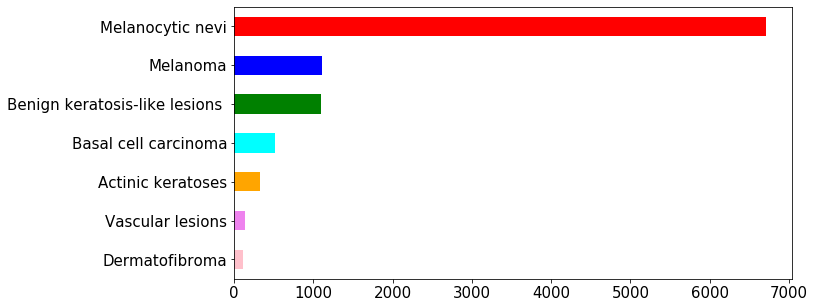

In [10]:
figsize= (10, 5)
fontsize=(15)
skincancerdf['type'].value_counts(ascending=True).plot(kind='barh', figsize = figsize, fontsize=fontsize, color=['pink', 'violet', 'orange', 'cyan', 'green', 'blue', 'red'], rot= 0)
plt.show()

 **There is a high imbalance in the data set as more than six thousand images belong to the class Melanocytic Nevi**

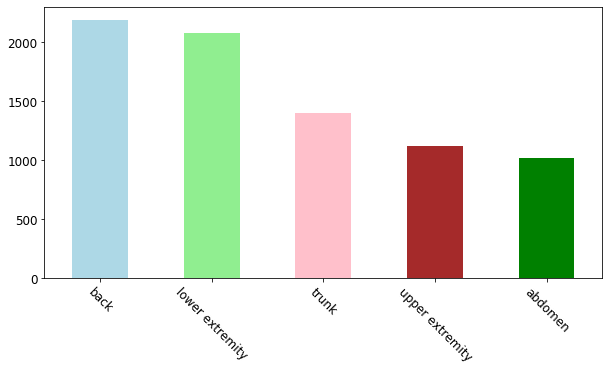

In [11]:
figsize= (10, 5)
fontsize=(12)
skincancerdf['localization'].value_counts(ascending=False).head(5).plot(kind='bar', figsize=figsize, color=['lightblue', 'lightgreen', 'pink', 'brown', 'green'], fontsize=fontsize, rot=-45)
plt.show()

**Top Five Localization Areas**  

## Step 3: Noise Removal using Morphological Operations 

**Dilation adds pixels on the object boundaries in an image while Erosion removes pixels from the object in an image. This helps us get rid of the body hair in the images which act as noise**

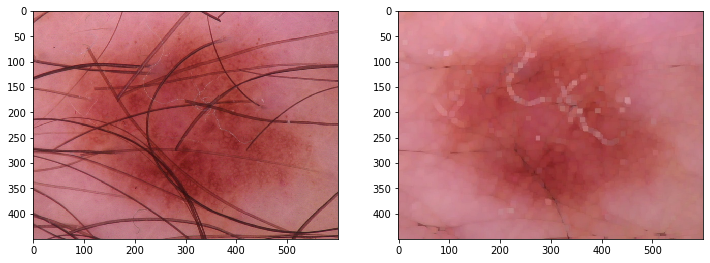

In [12]:
 img = Image.open('D:\\Python use case practice\\Skin Cancer\\HAM10000\\ISIC_0024397.jpg')
img_new = Image.open('D:\\Python use case practice\\Skin Cancer\\New folder\\HAM\\ISIC_0024397.jpg')
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

fig.add_subplot(1,2,1)
plt.imshow(img)

# display the new image
fig.add_subplot(1,2,2)
plt.imshow(img_new)

plt.show(block=True)

**Before Erosion and Dilation (Left)  After Erosion and Dilation (Right)**

In [13]:
# using cv2 package for Erosion and Dilation
path = "F:\\Skin_Cancer\\abc\\"
images = [f for f in os.listdir(path) if os.path.splitext(f)[-1] == '.jpg']
for image in images:
    img = cv2.imread(path+image)
    kernel = np.ones((5,5), np.uint8)        # 5 x 5 structuring element
    img_erosion = cv2.erode(img, kernel, iterations=1)
    img_dilation = cv2.dilate(img, kernel, iterations=2)
    cv2.imwrite('F:\\Skin_Cancer\\bcd\\'+image, img_dilation)

## Step 4: Resizing and Loading the images into the Dataframe 

**The original images are 600 x 450 pixels in size which can't be used in Keras so we resize them to 100 x 75 pixels. This size has been chosen after experimenting with different sizes.** 

In [12]:
skincancerdf['image'] = skincancerdf['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [13]:
skincancerdf.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,type,type_id,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,F:\Skin_Cancer\Final\HAM10000\ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[189, 149, 186], [192, 154, 193], [199, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,F:\Skin_Cancer\Final\HAM10000\ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 15, 26], [60, 42, 68], [107, 81, 116], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,F:\Skin_Cancer\Final\HAM10000\ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 134, 147], [198, 146, 159], [196, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,F:\Skin_Cancer\Final\HAM10000\ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[32, 16, 27], [88, 57, 73], [128, 80, 96], [..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,F:\Skin_Cancer\Final\HAM10000\ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[153, 111, 133], [189, 143, 172], [208, 158,..."


**There are two ways of loading image data into a model** 

**1. Flow Data From Directory** 

**2. Flow Data From DataFrame**

**We will flow the image data from the dataframe since we get to use other features along with the images which will help our model to learn better** 

## Step 5: Splitting the data into Train, Validation and Test and performing Normalization

In [14]:
features = skincancerdf.drop(columns=['type_id'],axis=1) #Independent Variables
target = skincancerdf['type_id'] #Dependent Variable

In [15]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=18124739)

In [16]:
#Images are normalised to ensure equal distribution of pixels across the entire image
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [17]:
#One Hot Encoding is performed on the disease types
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [18]:
# Splitting the Training data into train and validation data
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 18124739)

In [19]:
# Reshaping data into 3D format
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

## Step 6: Data Augmentation

**As we saw earlier our classes are highly imbalanced, so in order to balance our dataset and avoid overfitting we perform Data Augmentation on our training data**

In [20]:

datagen = ImageDataGenerator(
        rotation_range=10,  # rotates the images randomly with 10 degrees
        zoom_range = 0.1, # zooms an image randomly with a range of 0.1 
        width_shift_range=0.1,  # shifts the width of an image randomly by o.1 
        height_shift_range=0.1,  # shifts the height of an image randomly by o.1
        horizontal_flip=False,  # performs flips on images horzontally
        vertical_flip=False)  # performs flips on images vertically

datagen.fit(x_train)

## Step 7: Model Creation 

**We use Transfer Learning to reduce computing costs and obtain better results. After a lot of trial and error VGG19 model has been chosen for skin lesion classification**

In [37]:
# We load the VGG19 base model from the keras applications
base_model = tensorflow.keras.applications.VGG19(
    weights='imagenet',    #we use imgenet weights
    include_top=False,     #we do not include the top layer
    input_shape=(75, 100, 3)
)
base_model.trainable = False

In [38]:
# Define model
def model():
    model = base_model.output
    model = tensorflow.keras.layers.GlobalAveragePooling2D()(model) #we add one Global Average Pooling Layer 
    model = tensorflow.keras.layers.Dense(units=512, activation='relu')(model) # One Dense Layer
    model = tensorflow.keras.layers.Dropout(0.5)(model)  #set a Dropout rate of 0.5 to avoid overfitting
    predictions = tensorflow.keras.layers.Dense(units=7, activation='softmax')(model)  #we  add a fully connected layer with 
                                                                                       #softmax activation function for 
                                                                                       #class prediction
    model = tensorflow.keras.models.Model(inputs=base_model.input, outputs=predictions) 
    return model
model = model()

In [39]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 25, 128)       0   

In [24]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [25]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [26]:
# Set a learning rate annealer to avoid the problem of vanishing gradient descent
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [32]:
# Fit the model
epochs = 40 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/40
721/721 [==============================] - 61s 84ms/step - loss: 0.6178 - accuracy: 0.7741 - val_loss: 0.6691 - val_accuracy: 0.7469
Epoch 2/40
721/721 [==============================] - 70s 97ms/step - loss: 0.6192 - accuracy: 0.7728 - val_loss: 0.6678 - val_accuracy: 0.7481
Epoch 3/40
721/721 [==============================] - 66s 92ms/step - loss: 0.6130 - accuracy: 0.7807 - val_loss: 0.6685 - val_accuracy: 0.7481
Epoch 4/40
721/721 [==============================] - 68s 95ms/step - loss: 0.6057 - accuracy: 0.7825 - val_loss: 0.6685 - val_accuracy: 0.7494
Epoch 5/40
721/721 [==============================] - 68s 94ms/step - loss: 0.6084 - accuracy: 0.7756 - val_loss: 0.6688 - val_accuracy: 0.7469
Epoch 6/40
721/721 [==============================] - 68s 94ms/step - loss: 0.6158 - accuracy: 0.7710 - val_loss: 0.6682 - val_accuracy: 0.7469
Epoch 7/40
720/721 [============================>.] - ETA: 0s - loss: 0.6177 - accuracy: 0.7753 ETA: 1s
Epoch 00007: ReduceLROnPlateau r

## Step 8: Model Evaluation

In [33]:
# plot the model loss and accuracy
train_loss = history.history['loss']
train_acc = history.history['accuracy']

valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

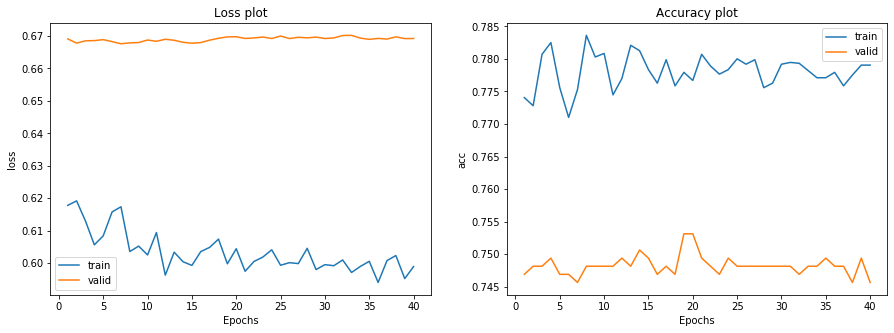

In [34]:
x = [(i+1) for i in range(len(train_loss))]

f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(x, train_loss)
ax[0].plot(x, valid_loss)
ax[0].set_title("Loss plot")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'valid'])


ax[1].plot(x, train_acc)
ax[1].plot(x, valid_acc)
ax[1].set_title("Accuracy plot")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("acc")
ax[1].legend(['train', 'valid'])

plt.show()

**We can see from tha above loss vs epoch plot that the model is not able to learn more and reduce the loss below 0.65 and from the accuracy plot we can see that the model is able to generalize well as it gets good accuracy even on validation data. So we can say that the model is not overfitting the training data**

In [32]:
model.save('D:\\NCI_Course\\Research Thesis\\Model_Save\\VGG19_dataframeaug.h5')

In [ ]:
model = tensorflow.keras.models.load_model('model.h5')

### Checking our model on test data we see that we get a test accuracy of 74%

In [35]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

2003/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Plotting Confusion Matrix

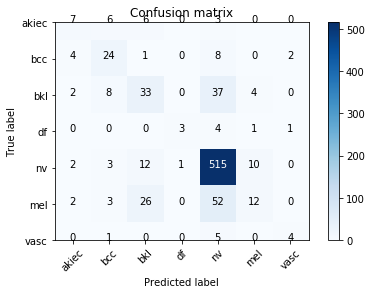

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv','mel', 'vasc']
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = cm_plot_labels)